Comparing full dataframe and FS results

In [1]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import mean_squared_error


# ---------- Load ----------
with open('Data/Final_Predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)

# ---------- Helpers ----------
def rmse(y_true, y_pred):
    return mean_squared_error(y_true,y_pred)**0.5

# ---------- Aggregate across folds ----------
rows = []

for dataset_name, folds in predictions.items():
    # Get the set of models by peeking at any fold
    all_models = set()
    for fold_name, fold_dict in folds.items():
        all_models.update(fold_dict.keys())
    all_models = sorted(all_models)

    for model_name in all_models:
        rmse_full_list = []
        rmse_bestk_list = []
        ks = []

        for fold_name, fold_dict in folds.items():
            if model_name not in fold_dict:
                continue

            entry = fold_dict[model_name]
            y_test = entry.get("y_test", None)
            y_full = entry.get("y_test_full_pred", None)
            y_bestk = entry.get("y_test_bestk_pred", None)
            k_val = entry.get("best_k", None)

            # Full RMSE
            if y_test is not None and y_full is not None:
                try:
                    rmse_full_list.append(rmse(y_test, y_full))
                except Exception:
                    pass

            # Best-k RMSE + k tracking (only if best-k preds exist)
            if y_test is not None and y_bestk is not None:
                try:
                    rmse_bestk_list.append(rmse(y_test, y_bestk))
                    if isinstance(k_val, int):
                        ks.append(k_val)
                except Exception:
                    pass

        # Averages across folds
        rmse_full_mean = float(np.mean(rmse_full_list)) if rmse_full_list else None
        rmse_bestk_mean = float(np.mean(rmse_bestk_list)) if rmse_bestk_list else None
        k_mode = np.mean(ks)

        rows.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Best_K": k_mode,
            "RMSE_BestK": rmse_bestk_mean,
            "RMSE_Full": rmse_full_mean,
            "Delta_BestK_minus_Full": (
                None if (rmse_bestk_mean is None or rmse_full_mean is None)
                else rmse_bestk_mean - rmse_full_mean
            )
        })

# ---------- To DataFrame ----------
df_summary = pd.DataFrame(rows).sort_values(["Dataset", "Model"]).reset_index(drop=True)

# Optional: save to disk
# df_summary.to_csv("Data/Final_RMSE_Summary.csv", index=False)

print(df_summary.head(20))


               Dataset                                  Model  Best_K  \
0   Airfoil_Self_Noise                    AdaBoost Regression    12.0   
1   Airfoil_Self_Noise               Decision Tree Regression    37.0   
2   Airfoil_Self_Noise  Extremely Randomized Trees Regression    37.0   
3   Airfoil_Self_Noise           Gradient Boosting Regression    33.0   
4   Airfoil_Self_Noise                         KNN Regression    23.0   
5   Airfoil_Self_Noise                    LightGBM Regression    35.0   
6   Airfoil_Self_Noise                      Linear Regression    35.0   
7   Airfoil_Self_Noise                         MLP Regression    38.0   
8   Airfoil_Self_Noise               Random Forest Regression    38.0   
9   Airfoil_Self_Noise                         SVM Regression    31.0   
10  Airfoil_Self_Noise                     XGBoost Regression    38.0   
11            Auto_MPG                    AdaBoost Regression    21.0   
12            Auto_MPG               Decision Tree 

In [11]:
# Count positives and negatives
num_positive = (df_summary["Delta_BestK_minus_Full"] > 0).sum()
num_negative = (df_summary["Delta_BestK_minus_Full"] < 0).sum()
num_zero = (df_summary["Delta_BestK_minus_Full"] == 0).sum()
print("Positive count:", num_positive)
print("Negative count:", num_negative)
print("Zero count:", num_zero)

Positive count: 87
Negative count: 122
Zero count: 0


C:\Users\25644574\AppData\Local\Temp\ipykernel_11440\432219630.py:32: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts.pivot_table(index="Model", columns="Outcome", values="Count", fill_value=0)


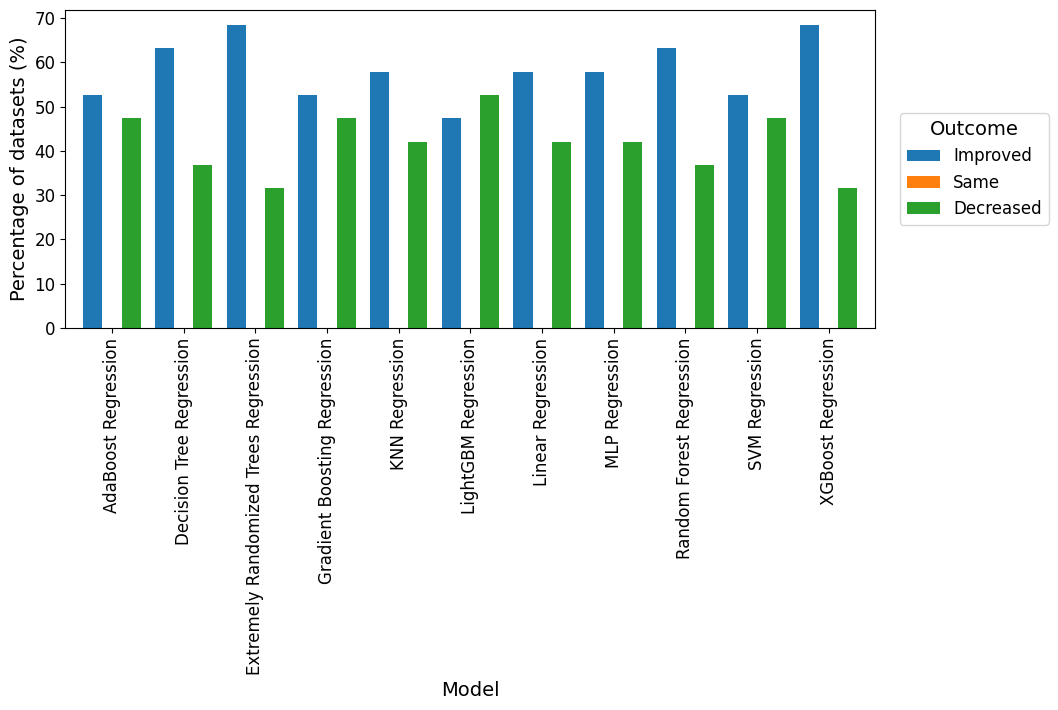

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- config ---
eps = 1e-9  # tolerance for "Same" due to floating-point noise

# --- classify each row ---
def classify(delta):
    if delta < -eps:
        return "Improved"
    elif abs(delta) <= eps:
        return "Same"
    else:
        return "Decreased"

df = df_summary.copy()
df["Outcome"] = df["Delta_BestK_minus_Full"].apply(classify)

# --- count per Model x Outcome ---
counts = (
    df.groupby(["Model", "Outcome"])
      .size()
      .reset_index(name="Count")
)

# ensure all three outcomes appear as columns (even if some counts are zero)
outcome_order = ["Improved", "Same", "Decreased"]
counts["Outcome"] = pd.Categorical(counts["Outcome"], categories=outcome_order, ordered=True)

wide = (
    counts.pivot_table(index="Model", columns="Outcome", values="Count", fill_value=0)
          .reindex(columns=outcome_order)
          .sort_index()
)

# --- convert counts to percentages ---
percentages = wide.div(wide.sum(axis=1), axis=0) * 100

# --- plot grouped bar chart ---
fig, ax = plt.subplots(figsize=(12, 6))
percentages.plot(kind="bar", ax=ax, width=0.8)

# Vertical tick labels directly under bars
ax.set_xticks(range(len(percentages.index)))
ax.set_xticklabels(percentages.index, rotation=90, ha='center', fontsize=12)

# Labels and legend
ax.set_xlabel("Model", fontsize=14)
ax.set_ylabel("Percentage of datasets (%)", fontsize=14)
ax.tick_params(axis='y', labelsize=12)

# Move legend outside
ax.legend(
    title="Outcome",
    title_fontsize=14,
    fontsize=12,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

# Adjust to make space for vertical labels
plt.subplots_adjust(bottom=0.35, right=0.8)
# Save to PDF (this must come before plt.show())
plt.savefig("Improvements_Exhaustive_FS.pdf", format='pdf')
plt.show()


Changing format

In [13]:
# Remove unwanted columns
df_summary = df_summary.drop(columns=['Best_K', 'RMSE_Full', 'Delta_BestK_minus_Full'])

# Rename RMSE_BestK to Test_RMSE
df_summary = df_summary.rename(columns={'RMSE_BestK': 'Test_RMSE'})

# Add Method column with 'EFS' for all rows
df_summary['Method'] = 'EFS'


Saving it

In [14]:
import pickle

# Save the dataframe to a pickle file
with open('Data/df_summary.pkl', 'wb') as f:
    pickle.dump(df_summary, f)
